# Particle tracking for vulnerability analysis, a synthetic model

This tutorial presents the capabilities of the `tracktools` python package for vulnerability analysis of production wells or drains. `tracktools` is designed for `MODFLOW6` and `MODPATH7`. The illustration is based on a synthetic groundwater flow model with an unstructured quad-tree grid.

### Notebook environment setup

In [23]:
# ---- Built-in module and local settings
import os, sys
sys.path.append(os.path.join(os.getcwd(),'..'))
gis_dir = 'gis'
exe_dir = os.path.join('..','exe')
gridgen_exe = os.path.join(exe_dir, 'gridgen')
#mf6_exe = os.path.join(exe_dir, 'mf6')
#mp7_exe = os.path.join(exe_dir, 'mp7')
mf6_exe = 'mf6'
mp7_exe = 'mp7'

# ---- Import packages
import numpy as np
import pandas as pd
import geopandas as gpd
import flopy
from flopy.utils.gridgen import Gridgen
import shapely
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

# ---- Print used version of each packages
print(sys.version)
print('geopandas version: {}'.format(gpd.__version__))
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))
print('geopandas version: {}'.format(gpd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))

3.8.2 (v3.8.2:7b3ab5921f, Feb 24 2020, 17:52:18) 
[Clang 6.0 (clang-600.0.57)]
geopandas version: 0.10.2
numpy version: 1.21.2
flopy version: 3.3.5
geopandas version: 0.10.2
matplotlib version: 3.3.4


### Case description

We consider an heterogeneous aquifer in a `3.75 km x 5 km` rectangle domain with production wells *w1* and *w2*, and a drain *d1*, surrounded by a series of contaminated zones (*z1*, *z2*, *z3*). The aquifer interacts with a river, which may also be a source of contamination. A constant head condition is set on the southern border. The river is divided into 3 reaches : *r1*, *r2*, *r3*. Spatial discretisation is DISV with a `50x50m` base grid resolution with nested refinements in the vicinity of river reaches, wells and drains. 

<div>
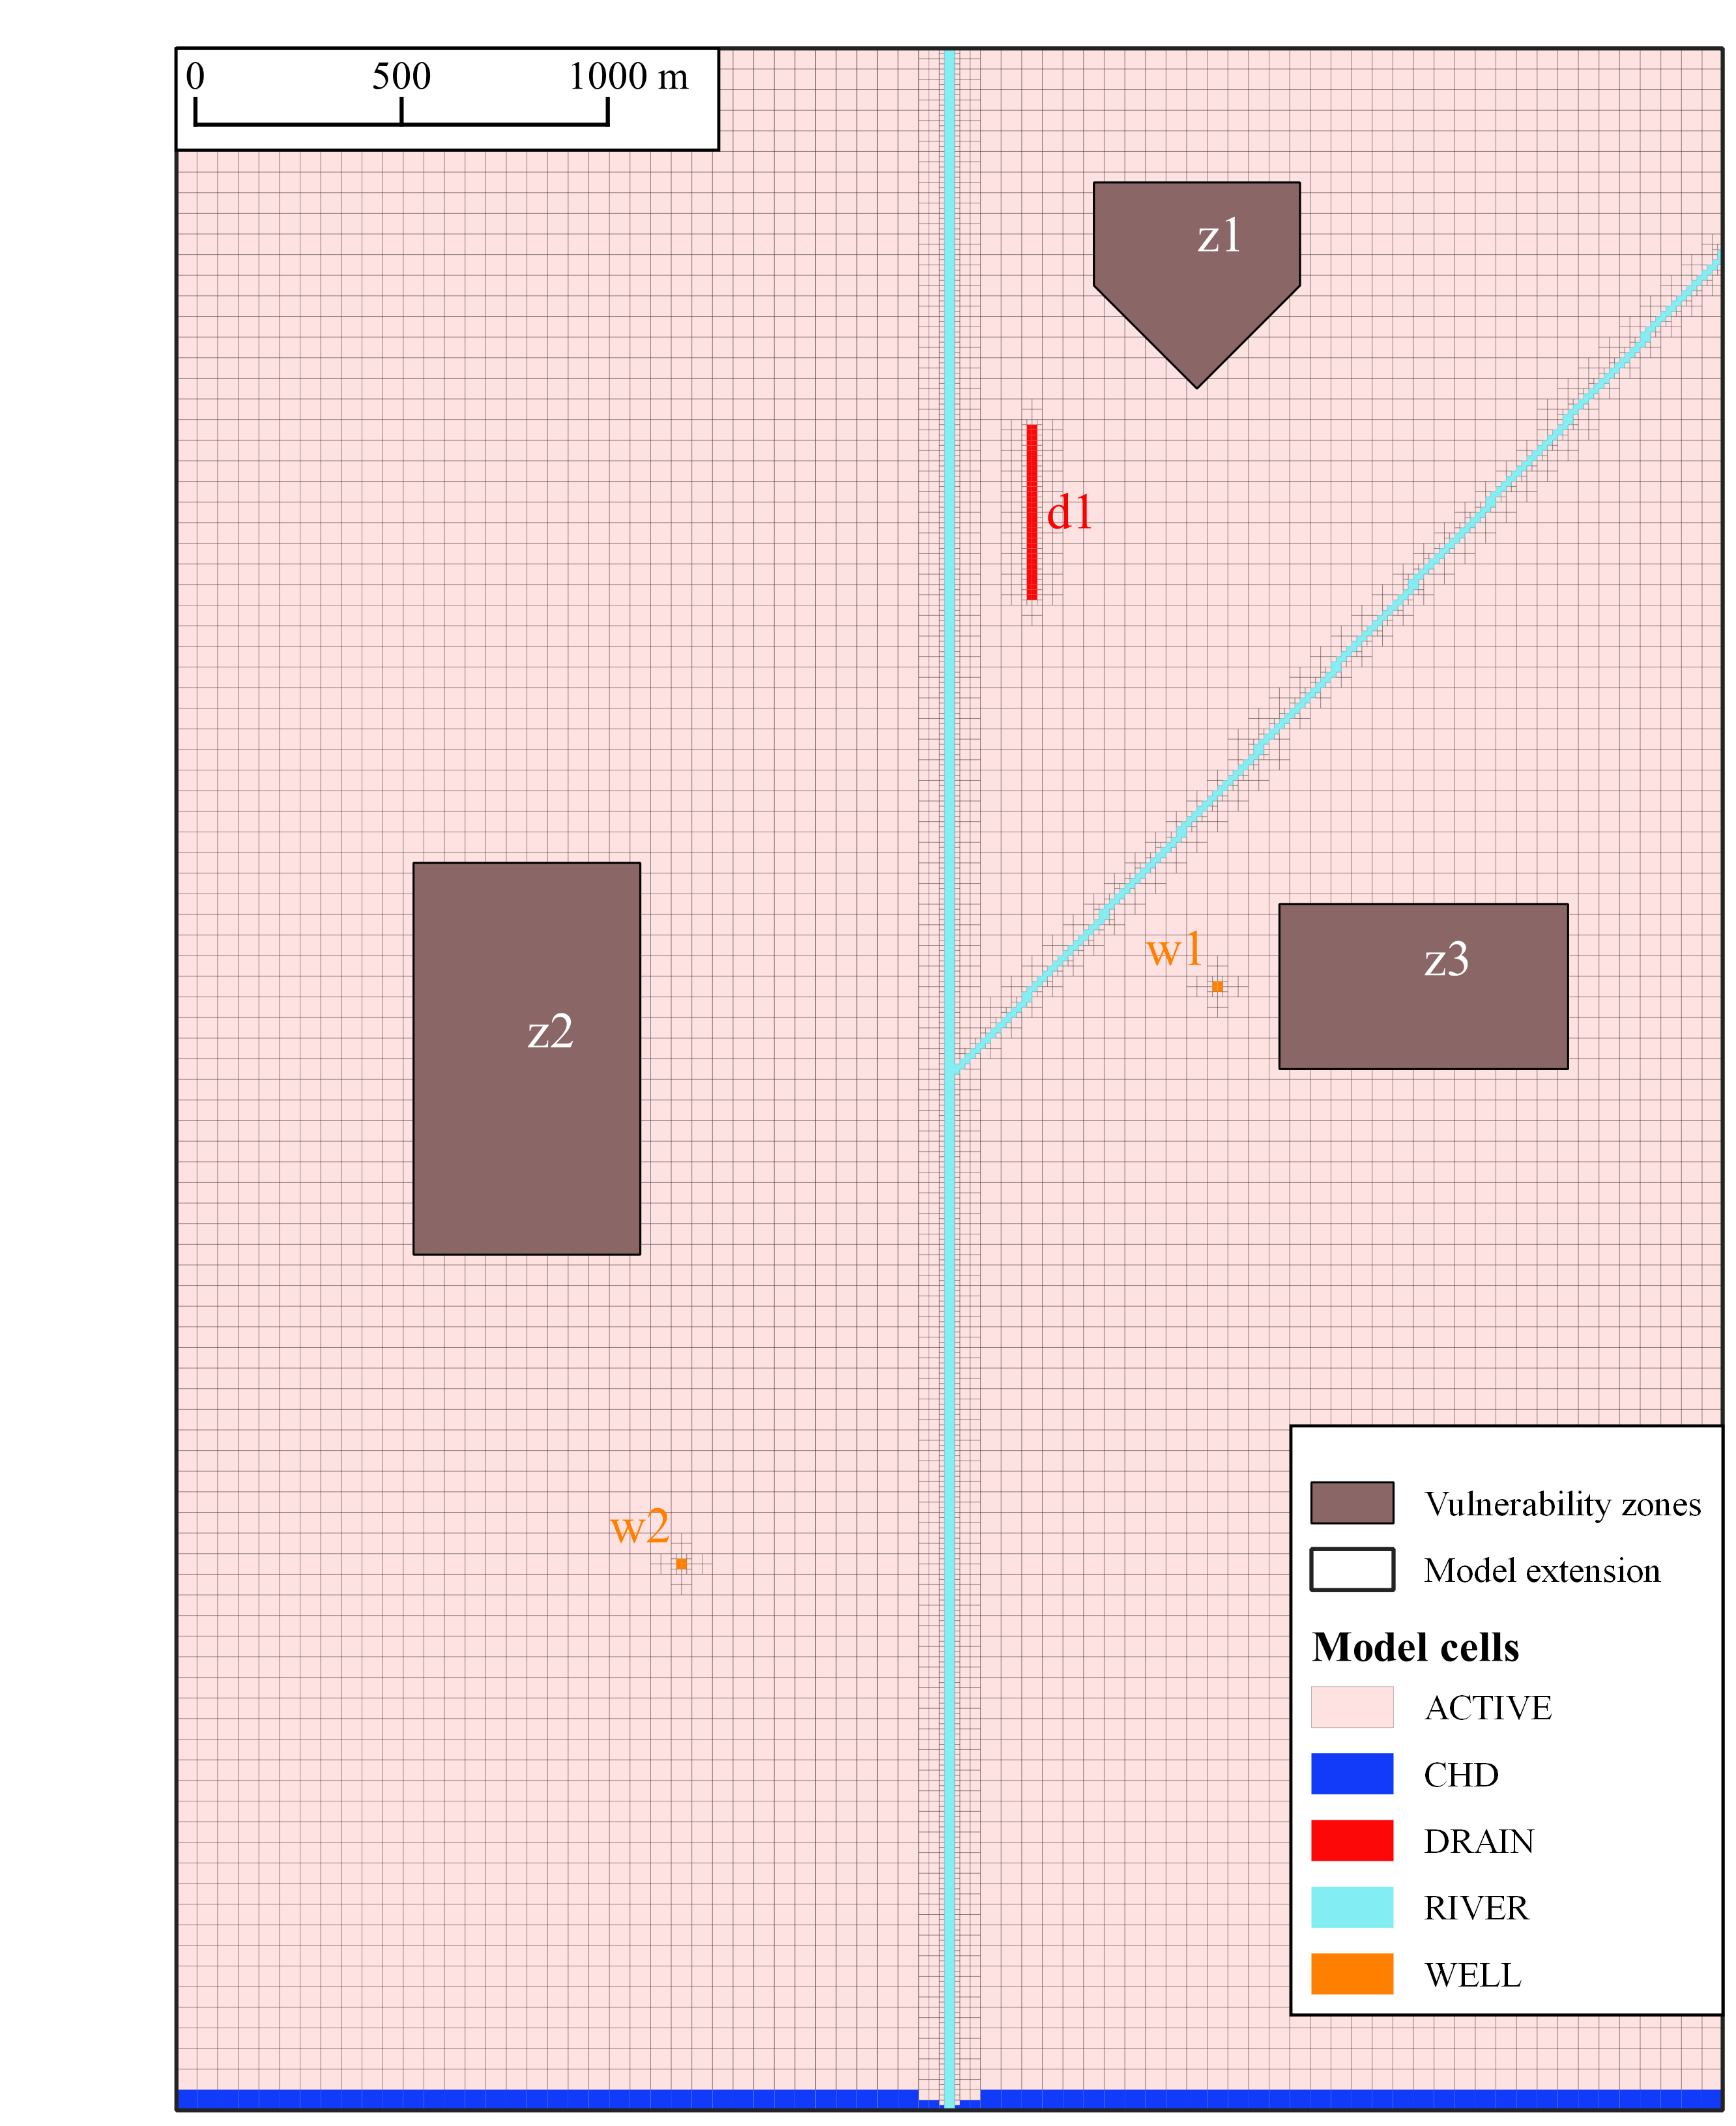
</div>

<div>
   <img src="attachment:intro_synmodel.png" width="300">
</div>

### Loading existing ground water flow model

The Modflow6 files of the model have been created in the `ml` folder with the `ml_setup.py` script. 

In [25]:
# load simulation object
ml_dir ='ml'
sim = flopy.mf6.MFSimulation.load(sim_ws=ml_dir)

# set mf6 executable
sim.exe_name = mf6_exe

# load ModflowGwf model
gwf = sim.get_model('syn_model')

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package drn...
    loading package riv...
    loading package wel...
    loading package rch...
    loading package oc...
  loading ims package syn_model...


#### Run ground water flow model

In [26]:
sim.run_simulation()

FloPy is using the following executable to run the model: /Users/apryet/Programmes/modflow/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.1.0 12/12/2019

  MODFLOW 6 compiled Apr  2 2020 21:54:43 with GFORTRAN compiler (ver. 6.3.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USG

(True, [])

#### Plot heads results 

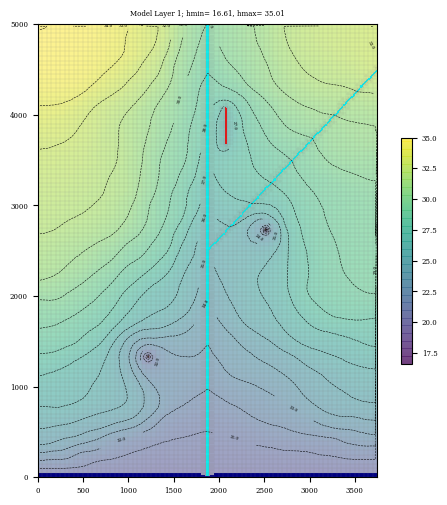

In [22]:
# get head data
ilay = 0
hds = sim.simulation_data.mfdata[gwf.name,'HDS','HEAD'][-1,ilay,-1,:]

# figure settings
plt.rc('font', family='serif', size=7)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect = 'equal')
ax.tick_params(axis='both', which='major', labelsize=5)

# build MapPlotView object
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax)

# plot head data
heads = pmv.plot_array(hds, masked_values=[1.e+30], alpha=0.5)
cb = plt.colorbar(heads, shrink = 0.5)
cb.ax.tick_params(labelsize=5)

# plot contours
hmin, hmax = hds.min(), hds.max()
levels = np.arange(np.floor(hmin), np.ceil(hmax), 1)
contours = pmv.contour_array(hds, masked_values=[1.e+30], 
                                  levels=levels, linewidths = 0.4,
                                  linestyles = 'dashed', colors = 'black')
contours.clabel(fmt = '%1.1f', inline=True, colors = 'black', inline_spacing = 20, fontsize = 3)

# set boundaries colors
bc_colors_dic = { 'RIV': 'cyan', 'DRN': 'red', 'CHD': 'navy', 'WEL': 'coral'}
for bc in bc_colors_dic.keys():
        quadmesh = pmv.plot_bc(bc, color = bc_colors_dic[bc])
        
# set title
ax.set_title('Model Layer {}; hmin={:6.2f}, hmax={:6.2f}'.format(ilay + 1, hmin, hmax), fontsize = 5)

# plot grid
pmv.plot_grid(lw = 0.05)

### Seeding particles  

The `ParticleGenerator` tool generates particles with different methods and process all data required by `mp7`. A `ParticleGenerator` instance can be initialized from an instance of `flopy.mf6.mfmodel.MFModel`.


In [6]:
# ---- Import vulnerability utilities
from tracktools import ParticleGenerator

# shapefile dictionary
shpfiles = [f for f in os.listdir(gis_dir) if f.endswith('.shp')]
shp_dic = {f.split('.')[0] : os.path.join(gis_dir,f) for f in shpfiles}

# setup ParticleGenerator instance for current model
pg = ParticleGenerator(ml = gwf)

# particle seeding settings 
d=20 # seeding distance, m
n_part=200 # number of particles per feature


/Users/apryet/Programmes/python/flopy/flopy/utils/gridintersect.py:322: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = icell


#### Extract particles data

To spatialize generated particles into the model grid, 4 informations of each particle are needed:
  - `locs` : node number of the cell in which the particule was generated
  - `local_x` : x-coordinate of the particule into the cell
  - `local_y` : y-coordinate of the particule into the cell
  - `pid` : unique particle id

Let's generate 1000 particles around each vulnerable boudary (wells and drain). To prevent the particles from stopping directly at a strong source during first timestep, it is preferable to set a suitable distance of particle generation from the boudary. The distance to choose to seed particules away from the production point (well or drain) is a delicate subject. It is up to the operator to find the best distance taking in account the capture zone of the facilities and the grid resolution of the model.

In this case we will consider that the minimum particle sowing distance must be strictly greater than the diagonal of the cell where the production facility is set.
So, let's assume that : *`generation distance > boundary cell resolution * sqrt(2)`*

In [7]:
# generate particles around wells 
pg.gen_points(shp_dic['wells'], dist=d, n_part = n_part, id_field='FID')

# ---enerate particles around drains 
pg.gen_points(shp_dic['drain'], dist=d, n_part = n_part, id_field='FID')


#### Save particles as shapefile

Sometimes it can be be usefull to get the generated particles as shapefile. There are 2 easy ways to do it:
- Using the basic geopandas `.to_file()` method
- Using the `ParticleBuilder` `export` argument while generating particles

In [8]:
'''
# ---- Set shapefile filenames
w1_filename = os.path.join(sig_dir, 'particles', 'w1_particles.shp')
drn_filename = os.path.join(sig_dir, 'particles', 'drain_particles.shp')

# 1) to_file() method
well_gdf.to_file(w1_filename)

# 2) export argument
drn_gdf = pb_drns.gen_npart(dist = 20, n_part = 200, export = drn_filename)
'''

"\n# ---- Set shapefile filenames\nw1_filename = os.path.join(sig_dir, 'particles', 'w1_particles.shp')\ndrn_filename = os.path.join(sig_dir, 'particles', 'drain_particles.shp')\n\n# 1) to_file() method\nwell_gdf.to_file(w1_filename)\n\n# 2) export argument\ndrn_gdf = pb_drns.gen_npart(dist = 20, n_part = 200, export = drn_filename)\n"

#### Build ParticleGroups

The `get_particle_groups` method returns a list of `flopy.modpath.mp7particlegroup.ParticleGroup` instances.

In [9]:
# ---- Build MODPATH7 ParticleGroup instances
pgid_file ='pgroups.csv'
particlegroups = pg.get_particlegroups(pgid_file=pgid_file)

###  PART 5 : Build & Run backward particle tracking model

#### Build MODPATH7 Model 

In [10]:
# ---- Choose a name for modpath model
mpname =  'mp_rv'

# ---- Build MODPATH7 model instance
mp = flopy.modpath.Modpath7(modelname= mpname, flowmodel= gwf,
                            model_ws = ml_dir, exe_name= mp7_exe)

# ---- Set default iface for MODFLOW 6
defaultiface6 = {'RCH': 6, 'EVT': 6}

# ---- Build MODPATH7 BAS package
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.1, defaultiface=defaultiface6)

# ---- Build MODPATH7 SIM package
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
                                      trackingdirection='backward',
                                      weaksinkoption='stop_at',
                                      weaksourceoption='stop_at',
                                      budgetoutputoption='summary',
                                      stoptimeoption='extend',
                                      particlegroups= particlegroups)

#### Write and Run MODPATH7 simulation

In [11]:
# ---- Write modpath files
mp.write_input()

# ---- Run modpath
mp.run_model()

FloPy is using the following executable to run the model: /Users/apryet/Programmes/modflow/bin/mp7

MODPATH Version 7.2.001   
Program compiled Apr  2 2020 22:09:01 with GFORTRAN compiler (ver. 6.3.0)       


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
       220 particles terminated at weak source cells.
       380 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

#### Plot pathlines

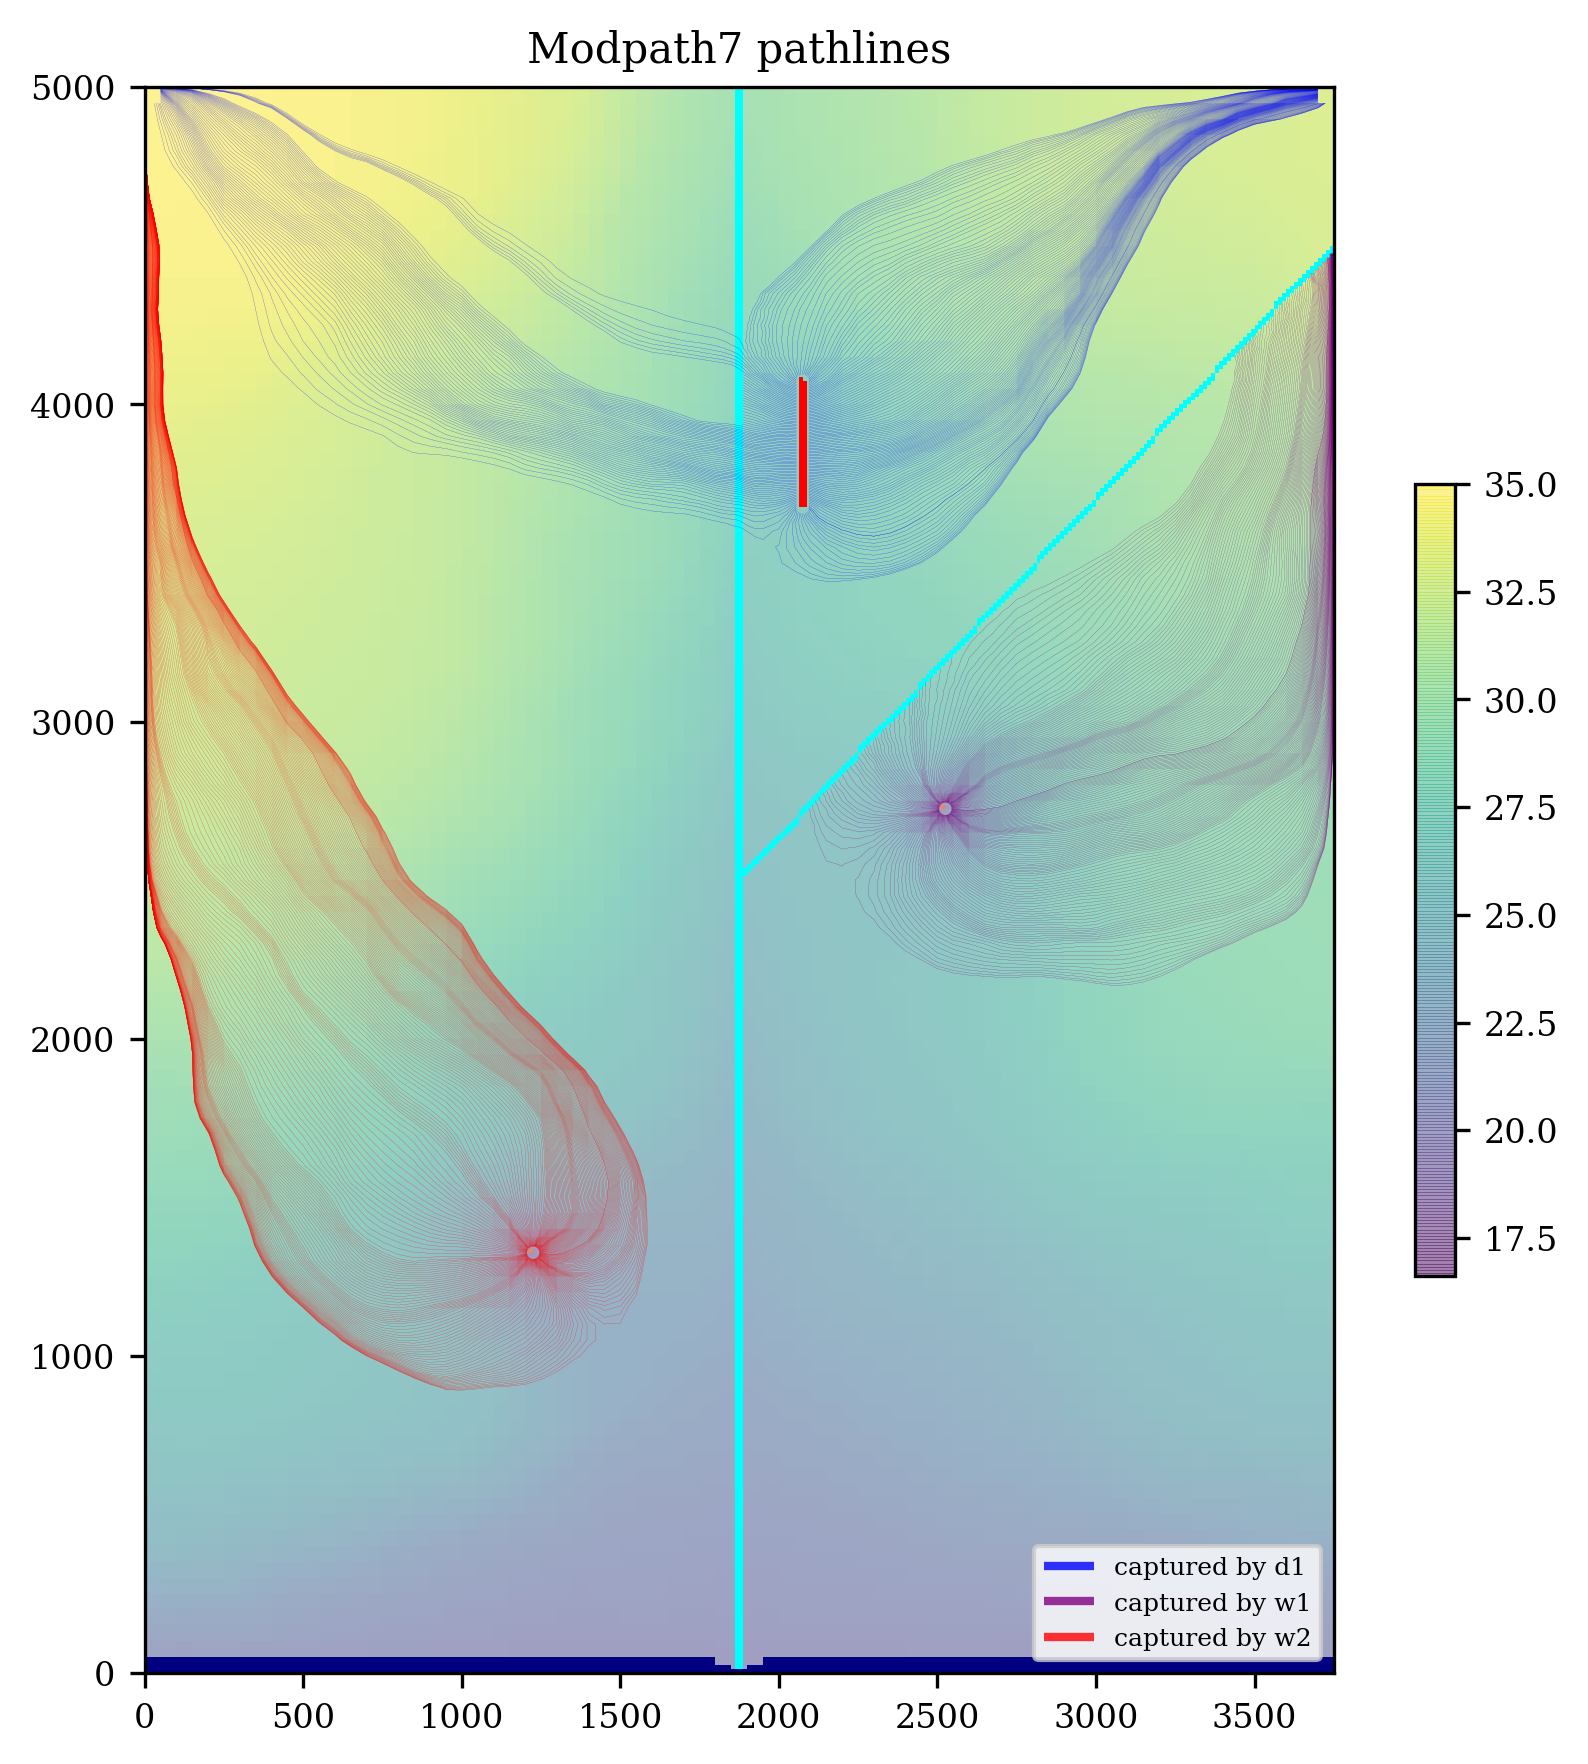

In [12]:
# # ---- Prepare axes for plot
plt.rc('font', family='serif', size=8)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Modpath7 pathlines' , fontsize=10)
 
# ---- Create Plot Map View object
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax)
pmv.plot_grid(lw = 0)
    
# ---- Plot heads as background
hds = sim.simulation_data.mfdata[gwf.name,'HDS','HEAD'][-1,-1,-1,:]
heads = pmv.plot_array(hds, masked_values=[1.e+30], alpha=0.5)
cb = plt.colorbar(heads, shrink = 0.5)

# ---- Plot pathlines for each group
pth = flopy.utils.PathlineFile(os.path.join(ml_dir,mpname + '.mppth'))
colors = ['blue', 'purple', 'red']
for pg, c in zip(particlegroups, colors):
    nodes = pg.particledata.particledata.node
    rec = pth.get_destination_pathline_data(nodes) 
    pmv.plot_pathline(rec, color = c, layer = 'all', lw = 0.03, alpha = 0.8,
                    label=f'captured by {pg.particlegroupname}')
# ---- Plot boundaries
bc_colors_dic = { 'RIV': 'cyan', 'DRN': 'red', 'CHD': 'navy', 'WEL': 'coral'}
for bc in bc_colors_dic.keys():
    bounds = pmv.plot_bc(bc, color = bc_colors_dic[bc])
    
# ---- Plot legend
leg = ax.legend(loc = 'lower right',fontsize = 6)
for line in leg.get_lines():
    line.set_linewidth(2)

### PART 6 : River vulnerability

Now let's focus on the river vulnerability of the water production facilities (wells and drain) by importing the `TrackingAnalyzer` class. 2 objects are required:
- `gwf`: the ground water flow model (`flopy.mf6.mfmodel.MFModel`) 
- `mpsim`: the advective transport simulation (`flopy.modpath.mp7sim.Modpath7Sim`)

In [16]:
from tracktools import TrackingAnalyzer

ta = TrackingAnalyzer(ml = gwf, mpsim = mpsim)

Note: Make sure that all the river cells on the `riv` package of the modflow ground water flow model has a `boundname` argument. If the river is not divided in reaches, just make sure to put a basic name such as `'river'`.

The `SSRV` object has many usefull attributs such as:
  - `pth` : Pathline data
  - `edp` : Endpoint data
  - `cbc` : CellBudget data
  - `river_leakage_df` : DataFrame with leakage data for each river cell
  - `flowja`, `ia` : cells connectivity

#### Compute mixing ratios

`SSRV` object allows computing the fraction of water that comes from the river at a given production point like a well or a drain. The value of the mixing ratio may range between **0** (ground water only) to **1** (surface water only).

For going further about mixing ratios : [Cousquer et al, 2018](https://hal.archives-ouvertes.fr/hal-02308252/ "Developing a particle tracking surrogate model to improve inversion of ground water Surface water models")


In [17]:
# ---- Compute mixing ratio 
mr = ta.compute_mixing_ratio()

# ---- Transform to percent
mr = mr * 100
display(mr.round(decimals = 2))

grpnme
d1     0.49
w1    48.84
w2     0.00
dtype: float64

#### Plot mixing ratio results

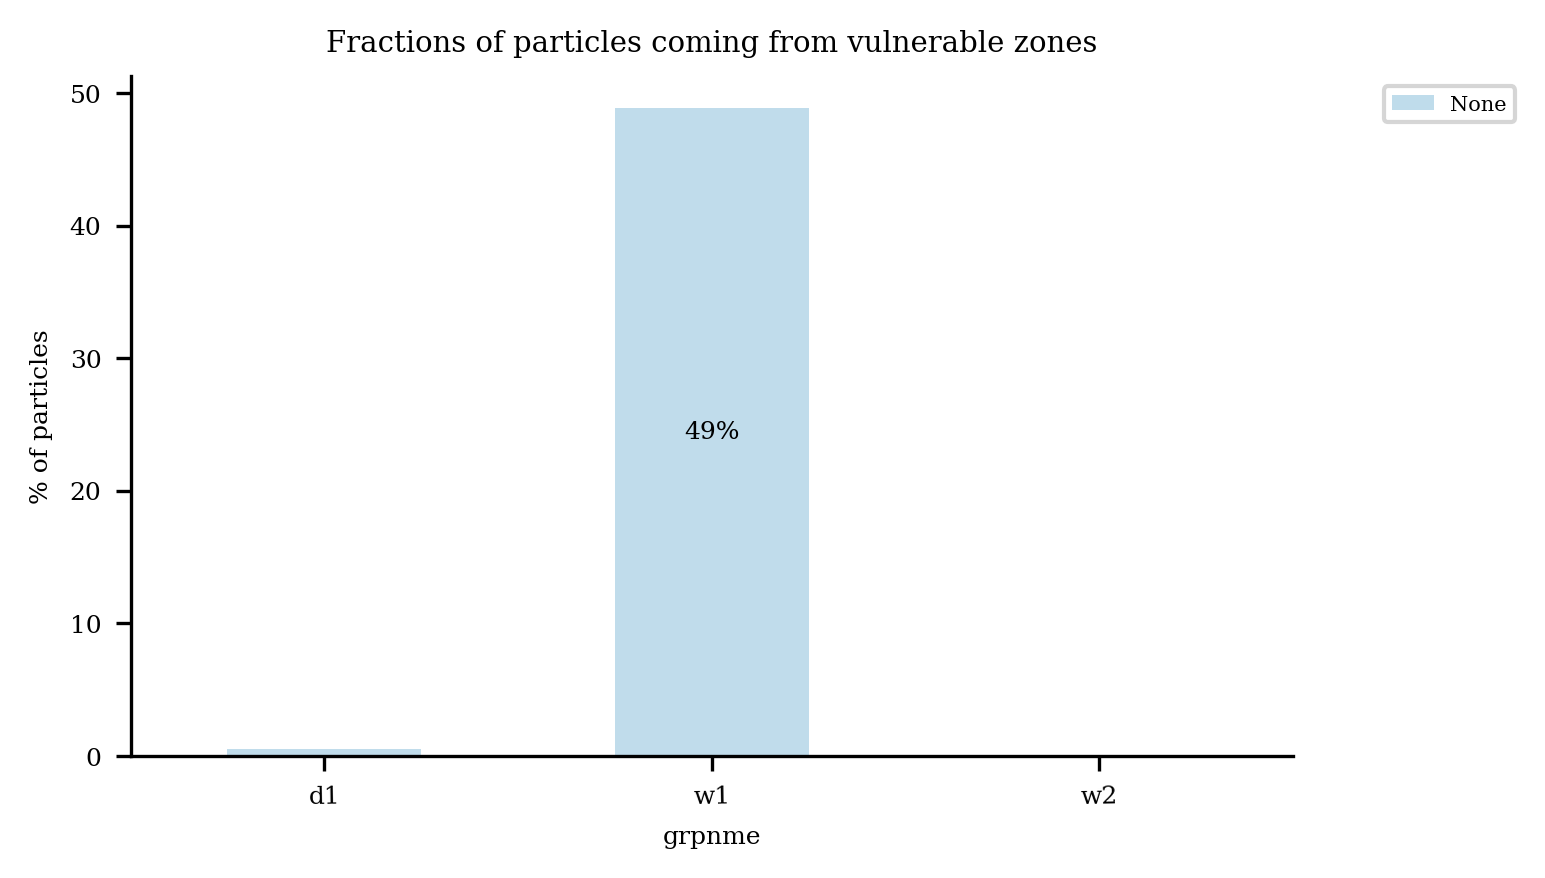

In [20]:
plt.rc('font', family='serif', size=6)

ax = mr.plot.bar(figsize=(5,3),cmap = 'Paired', stacked=True, alpha = 0.7, rot = 1)

plt.ylabel('% of particles')
plt.title('Fractions of particles coming from vulnerable zones', fontsize = 7)

# add value labels
for p in ax.patches:
    # Write text only for % > 2
    if p.get_height() > 2:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, y+height/2, '{:.0f}%'.format(height),
        fontsize = 6, ha='center', va='center')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc = 'upper right',bbox_to_anchor=(1.2, 1), fontsize = 5)

#### Aggregate reaches

`SSRV` object allows computing mixing ratios aggregating multiple reaches. Let's try to aggregate all reaches into one river instance to get a general river vulnerability for all facilities.

In [ ]:
# ---- Create a aggregation dictionary
agg_dic = {'river': ssrv.get_reach_names()}
print(agg_dic)

In [ ]:
# ---- Compute mixing ratio again
mr_df = ssrv.compute_mixing_ratio(agg_dic, filled = True)

# ---- Transform to percent
mr_df = mr_df * 100
display(mr_df.round(decimals = 2))

#### Plot mixing ratio results after aggregating reaches

In [ ]:
# ---- Prepare plot
plt.rc('font', family='serif', size=6)


# ---- Vertical bar plot
ax = mr_df.plot.bar(figsize=(5,3),cmap = 'Paired', stacked=True, alpha = 0.7, rot = 1)

# ----Set y-label
plt.ylabel('% of particles')

# ---- Set title
plt.title('Fractions of particles coming from vulnerable zones', fontsize = 7)

# ---- Add % in each bar
for p in ax.patches:
    # Write text only for % > 2
    if p.get_height() > 2:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, y+height/2, '{:.0f}%'.format(height),
        fontsize = 6, ha='center', va='center')

# ---- Hide axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ---- Show legend
plt.legend(loc = 'upper right',bbox_to_anchor=(1.2, 1), fontsize = 5)

### PART 7 : Zonal Vulnerability

Now let's focus on the zonal vulnerability of the water production facilities (wells and drain) by importing the `SSZV` *(Steady-State Zonal Vulnerability)* tool. To Build a `SSZV` instance 3 objects are needed:
- `gwf`: the ground water flow model (`flopy.mf6.mfmodel.MFModel`) 
- `mpsim`: the advective transport simulation (`flopy.modpath.mp7sim.Modpath7Sim`)
- `shp_name` or `geometry_dic`: shapefile path or dictionary of `shapely` geometries (polygon(s)) that contains vulnerability zones

####  Create a SSZV objet (Steady-State Zonal Vulnerability)

In [ ]:
# ---- Import Steady-State River Vulnerability instance
from vulnerability import SSZV

# ---- Create SSZV object
sszv = SSZV(gwf = gwf, mpsim = mpsim,
            shp_name = shp_dic['vul_zones'],
            field_id = 'FID')

# ---- SSZV instance infos
print(sszv)

#### Compute zonal vulnerability

`SSZV` tool allows to compute the number of particles that terminate in the water production facility from a given potential zone of contamination. This index can be calculate with or without ponderating the number of particle by their arrival velocity at the production point (`pond_velocity`). For an homogeneous hydraulic conductivity the velocity does not really matter.

In [ ]:
# ---- Compute zonal vulnerability in percent with particle velocity ponderation
s = time.time()
zv_df = sszv.compute_zonal_vulnerability(pond_velocity = True) * 100
exe_time = round(time.time()  - s, 2)
print(f'Execution time for {len(sszv.edp.get_alldata())} particles with velocity ponderation: {exe_time}s')
display(zv_df.round(decimals = 2))

# ---- Compute zonal vulnerability in percent without particle velocity ponderation
s = time.time()
zv_df_without_v = sszv.compute_zonal_vulnerability(pond_velocity = False) * 100
exe_time = round(time.time()  - s, 2)
print(f'Execution time for {len(sszv.edp.get_alldata())} particles without velocity ponderation: {exe_time}s')
display(zv_df_without_v.round(decimals = 2))

Note: This is a **semi-quantitative spatial method** that give a index ratio as `number of captured particles / total number of sown particles` where all the particles that touch or cross a given potential polluted zone are considered contiminated. Of course, the result of this method cannot be robust as the mixing ratio with the river discussed earlier but it works as a additionnal **indicator** of vulnerability analysis and give some informations about connections between groundwater withdraw facilities and polluted zones.

#### Plots results

In [ ]:
# ---- Prepare axes for plot
plt.rc('font', family='serif', size=8)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Modpath7 pathlines' , fontsize=10)
 
# ---- Create Plot Map View object
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax)
pmv.plot_grid(lw = 0)

# ---- Plot zones
sszv.vul_zone.plot(ax = ax,color = 'burlywood', edgecolor="black", lw=0.5, zorder = 10)
coords = sszv.vul_zone['geometry'].apply(lambda x: x.representative_point().coords[:])
sszv.vul_zone['rp'] = [coords[0] for coords in coords]
for idx, row in sszv.vul_zone.iterrows():
    plt.annotate(s=row['FID'], xy=row['rp'],
                 horizontalalignment='center',
                 fontsize = 7,
                 color = 'black',
                 zorder = 50)

# ---- Plot heads as background
hds = sim.simulation_data.mfdata[gwf.name,'HDS','HEAD'][-1,-1,-1,:]
heads = pmv.plot_array(hds, masked_values=[1.e+30], alpha=0.5)
cb = plt.colorbar(heads, shrink = 0.5)

# ---- Plot pathlines for each group
pth = flopy.utils.PathlineFile(mpname + '.mppth')
colors = ['blue', 'purple', 'red']
for pg, c in zip(particlegroups, colors):
    nodes = pg.particledata.particledata.node
    rec = pth.get_destination_pathline_data(nodes) 
    pmv.plot_pathline(rec, color = c, layer = 'all', lw = 0.03, alpha = 0.8,
                    label=f'captured by {pg.particlegroupname}')
# ---- Plot boundaries
bc_colors_dic = { 'RIV': 'cyan', 'DRN': 'red', 'CHD': 'navy', 'WEL': 'coral'}
for bc in bc_colors_dic.keys():
    bounds = pmv.plot_bc(bc, color = bc_colors_dic[bc])
    
# ---- Plot legend
leg = ax.legend(loc = 'lower right',fontsize = 6)
for line in leg.get_lines():
    line.set_linewidth(2)

#### Multiple particle intersections

It may happen that a particle can cross successively several polluted areas. This makes the zonal vulnerability study even more complex. Let's investigate this part by keeping focus on the `z2` zone and adding a additionnal zone (can correspond to a pesticide storage warehouse for example) represented as a square polygon `(150m*150m)` named `z4` on the north west of the production well `w2`.

In [ ]:
# ---- Fetch z2 zone geometry
z2_geom = sszv.vul_zone.loc[sszv.vul_zone[sszv.field_id] == 'z2', 'geometry'].values[0]

# ---- Build the new z3 zone
from shapely.geometry import Point
z4_geom = Point((850,1600)).buffer(150, cap_style = 3)

# ---- Create a new SSZV object
geom_dic = {vid:geom for vid,geom in zip(['z2', 'z4'],[z2_geom, z4_geom])}
sszv2 = SSZV(gwf = gwf, mpsim = mpsim, geometry_dic = geom_dic)

#### Plot venn diagram

In [ ]:
# ---- Prepare axes for plot
plt.rc('font', family='serif', size=6)
fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(1, 1, 1, aspect='equal')

# ---- Create Plot Map View object
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax0)
pmv.plot_grid(lw = 0)

# ---- Plot heads as background
hds = sim.simulation_data.mfdata[gwf.name,'HDS','HEAD'][-1,-1,-1,:]
heads = pmv.plot_array(hds, masked_values=[1.e+30], alpha=0.5)

# ---- Plot zones 
sszv2.vul_zone.plot(ax = ax0,color = ['darkgreen', 'orange'], edgecolor="black", lw=0.5, zorder = 10)
coords = sszv2.vul_zone['geometry'].apply(lambda x: x.representative_point().coords[:])
sszv2.vul_zone['rp'] = [coords[0] for coords in coords]
for idx, row in sszv2.vul_zone.iterrows():
    plt.annotate(s=row['FID'], xy=row['rp'],
                 horizontalalignment='center',
                 fontsize = 7,
                 color = 'black',
                 zorder = 50)

# ---- Plot pathlines for well w2
pth = flopy.utils.PathlineFile(mpname + '.mppth')
pg = [pg for pg in particlegroups if pg.particlegroupname == 'w2'][0]
rec = pth.get_destination_pathline_data(pg.particledata.particledata.node)
pmv.plot_pathline(rec, color = 'purple', layer = 'all', lw = 0.03, alpha = 0.8,
                    label=f'captured by {pg.particlegroupname}')

# ---- Plot boundaries
bc_colors_dic = { 'RIV': 'cyan', 'DRN': 'red', 'CHD': 'navy'}
for bc in bc_colors_dic.keys():
    bounds = pmv.plot_bc(bc, color = bc_colors_dic[bc])

# ---- Focus on z2, z4 areas
ax0.set_xlim((300,2300))
ax0.set_ylim((900,3200))

# ---- Plot legend
leg = ax0.legend(loc = 'lower right',fontsize = 6)
for line in leg.get_lines():
    line.set_linewidth(2)

# ---- Embedding venn diagram in main plot
embed_ax = inset_axes(ax0, width="50%",height='30%',loc=1, borderpad=0)
ax1,venn,circles = sszv2.plot_venn(ax = embed_ax, pg = 'w2',colors = ['darkgreen', 'darkorange'],
                                   lw = 0.25, alpha = 1, textsize=3.5)
embed_ax.set_title('Number of particles intersected', fontsize=6)
embed_ax.set_facecolor('black')

#### Manage multiple intersections zonal vulnerability

So, `539` particles out of the `1000` sown cross the `z2` zone, `110` particles cross the `z4` zone and `14` particles cross both areas. So, in order to calculate a unique understandable indicator 3 methods are available to manage this multiple intersections:
- `first` : consider only the first zone of vulnerability intersected
- `last`  : consider only the last zone of vulnerability intersected
- `all`   : consider all zones of vulnerability intersected

In [ ]:
# ---- Compute zonal vulnerability for each intersection method
dfs = []
for method in sszv2.get_methods():
    df = sszv2.compute_zonal_vulnerability(method = method) * 100
    dfs.append(df.loc['w2'].to_frame().T)

# ---- Concatenate all results in a single Data Frame
zv_df = pd.concat(dfs)
zv_df.index = sszv2.get_methods()
display(zv_df)

Note: For the `all` method, a particle can be considerated multiple times: in `z2`,` z4` or `z2 & z4` zones. That's the reason why the general indicator can be more than `100%`.